

# MSAAI-501 Intro to Artificial Intelligence
# Group 3 Final Project - Using Computer Vision to Predict Ocular Disease

Team Members:
  Elan Wilkinson,
  Ben Hopwood,
  Sarah Durrani


### Data Source and Description:

Date Source:
Maranhão, A. (2020, September 24). Ocular Disease Recognition: Right and left eye fundus photographs of 5000 patients. Kaggle. https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k  

Project Desciption: This project explored taking a fundal image to classify it as appearing healthy or indicative of:
  - diabetes
  - glaucoma
  - cataracts
  - age-related macular degeneration
  - hypertension
  - pathological myopia
  - or other diseases/concerns.
  
This team explored multiple approaches to determine which solution provides the best classification results. These include Convoluted Neural Networks (CNN), Residual Neural Networks (RNN), Support Vector Machines, YOLO, and ResNet. The project estimated the category of disease a fundal image would fall into and give a measure of the agent’s confidence in the classification. While accuracy and precision are paramount metrics to base performance on, the speed/memory required to perform the calculations was also considered.

### **Import Necessary Libraries:**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import random
import os
import shutil
import zipfile
import io

from tqdm import tqdm
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

## Exploratory Data Analysis

### Initial Read in of Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')


ocular_disease_filepath = "/content/drive/MyDrive/Colab Notebooks/ocular-disease-recognition-odir5k/data_processed.xlsx"

ocular_disease_df = pd.read_excel(ocular_disease_filepath)

Mounted at /content/drive


### Diagnoses of Ocular Disease Present in Dataset

The initial dataset initially had one-hot encoded columns for each of 8 eight eye conditions:
- N - Normal
- D - Diabetes
- G - Glaucoma
- C - Cataract
- A - Age Related Macular Degeneration
- H - Hypertension
- M - Pathological Myopia
- O - Other

### Correction of one-hot encoded labels to per-eye labeling

However, these were one-hot encoded as a diagnosis for the patient, not per eye. May of the diagnoses present were only applicable to one eye but not the other, causing incorrect labeling of image data. Manual modification of the excel file containing patient ocular data was performed in an external program to create one-hot encoded columns per eye.

In [3]:
ocular_disease_df.drop(['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'], axis=1, inplace=True)

### View of the Dataframe

In [4]:
ocular_disease_df.head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Left-N,Right-N,Left-D,...,Left-C,Right-C,Left-A,Right-A,Left-H,Right-H,Left-M,Right-M,Left-O,Right-O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Summary Statistics

In [ ]:
print("\nSummary Statistics:")
print(ocular_disease_df.describe())


Summary Statistics:
                ID  Patient Age       Left-N      Right-N       Left-D  \
count  3500.000000  3500.000000  3500.000000  3500.000000  3500.000000   
mean   2218.233143    57.854000     0.451429     0.435429     0.274000   
std    1415.437872    11.724064     0.497706     0.495884     0.446073   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%     876.750000    51.000000     0.000000     0.000000     0.000000   
50%    2372.500000    59.000000     0.000000     0.000000     0.000000   
75%    3247.250000    66.000000     1.000000     1.000000     1.000000   
max    4784.000000    91.000000     1.000000     1.000000     1.000000   

           Right-D       Left-G      Right-G       Left-C      Right-C  \
count  3500.000000  3500.000000  3500.000000  3500.000000  3500.000000   
mean      0.283429     0.050571     0.042571     0.045429     0.044000   
std       0.450727     0.219152     0.201918     0.208272     0.205124   
min       0.0000

### Data Visualization

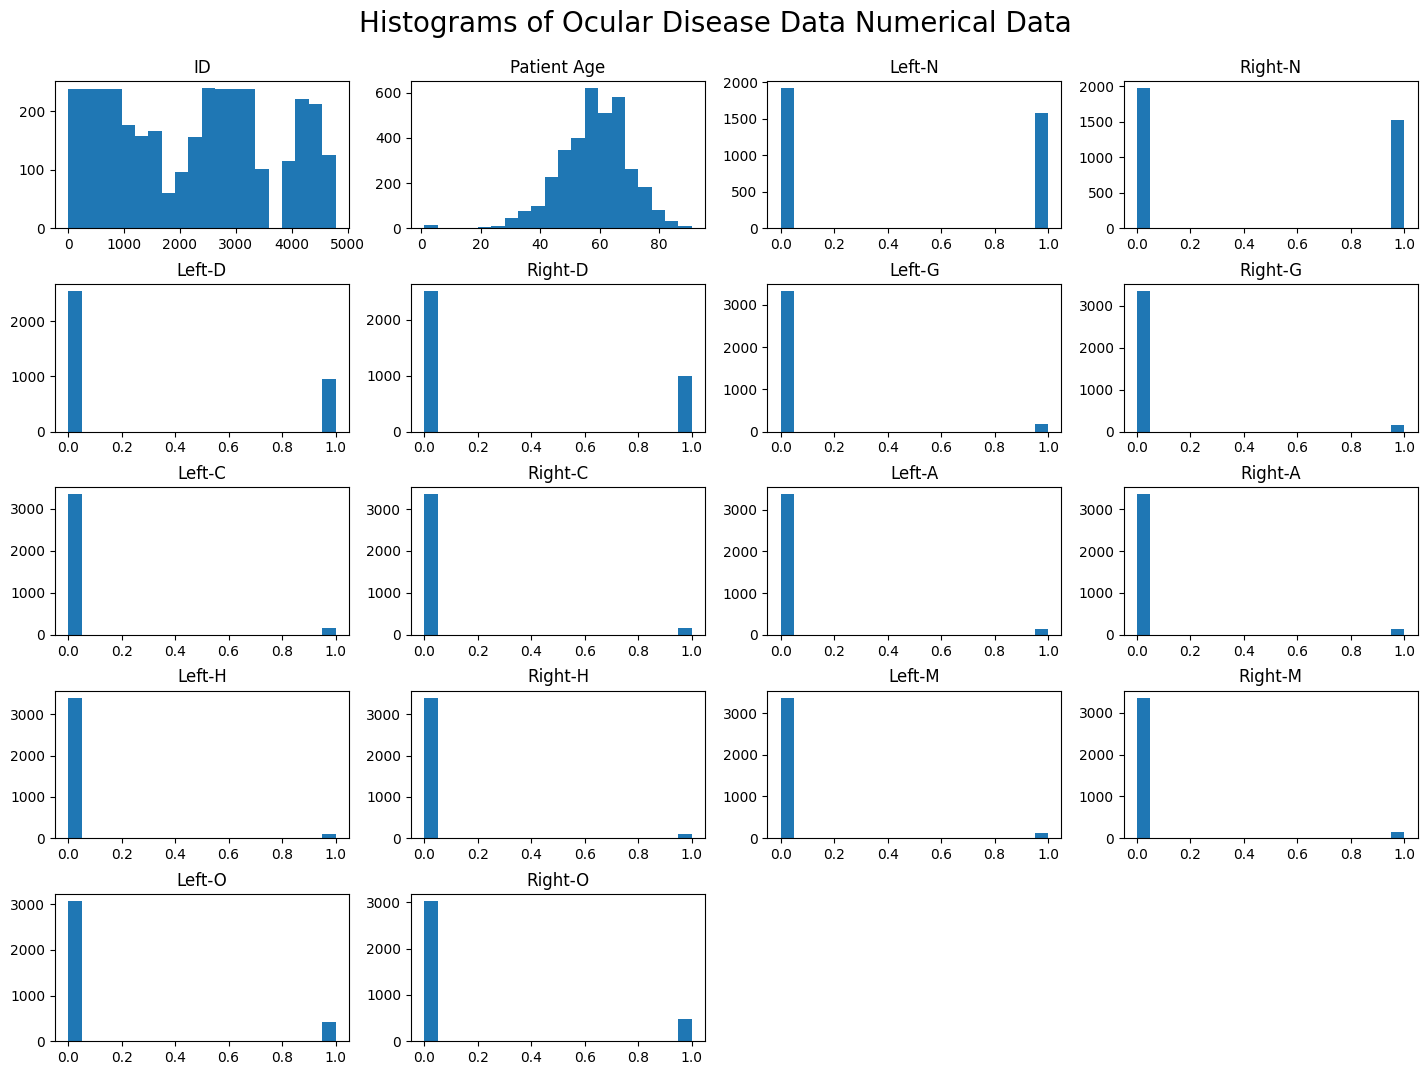

In [5]:
ocular_disease_df.hist(figsize=(12, 10), bins=20, grid=False)
plt.suptitle("Histograms of Ocular Disease Data Numerical Data\n", fontsize=20, y=1.07, x =.6)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.subplots_adjust(top=0.999)
plt.ylabel('No. of patients')
plt.grid(False)
plt.show()


### Patient Ages

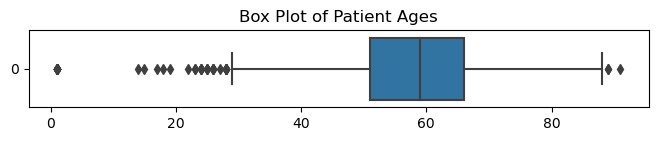

In [ ]:
# 2.2 Box Plots
plt.figure(figsize=(8, 1))
sns.boxplot(ocular_disease_df['Patient Age'], orient="h")
plt.title("Box Plot of Patient Ages")
plt.show()

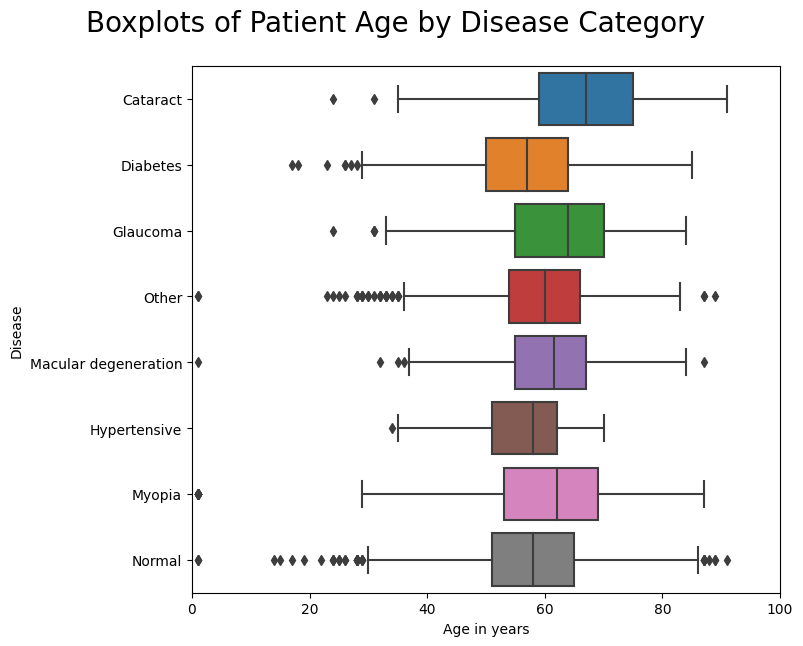

In [27]:
categs = ['C', 'D', 'G', 'O', 'A', 'H', 'M', 'N']

keyword_map = {
    'N': 'Normal',
    'D': 'Diabetes',
    'G': 'Glaucoma',
    'C': 'Cataract',
    'A': 'Macular degeneration',
    'H': 'Hypertensive',
    'M': 'Myopia',
    'O': 'Other'
}

def plot_by_agecat(ocular_disease_df, keyword_map):
    # Create a long-form DataFrame for plotting with Seaborn
    long_df = pd.DataFrame()
    for cat in categs:
        # Filter patients with the disease and extract 'Patient Age'
        df_by_cat = ocular_disease_df[((ocular_disease_df[f"Left-{cat}"] == 1) |
                                       (ocular_disease_df[f"Right-{cat}"] == 1))]
        df_by_cat = df_by_cat.assign(Disease=keyword_map[cat])
        long_df = pd.concat([long_df, df_by_cat[['Patient Age', 'Disease']]])

    # Create the boxplot with Seaborn
    sns.boxplot(data=long_df, y='Disease', x='Patient Age', orient='h')

# Setup for plotting
plt.figure(figsize=(8, 6))

# Plot boxplots for patients, passing the DataFrame and keyword_map as arguments
plot_by_agecat(ocular_disease_df, keyword_map)

plt.tight_layout()
plt.suptitle("Boxplots of Patient Age by Disease Category", fontsize=20, y=1.07, x =.5)
plt.xlabel("Age in years")
plt.xlim(0, 100)  # Set the x-axis limits
plt.show()


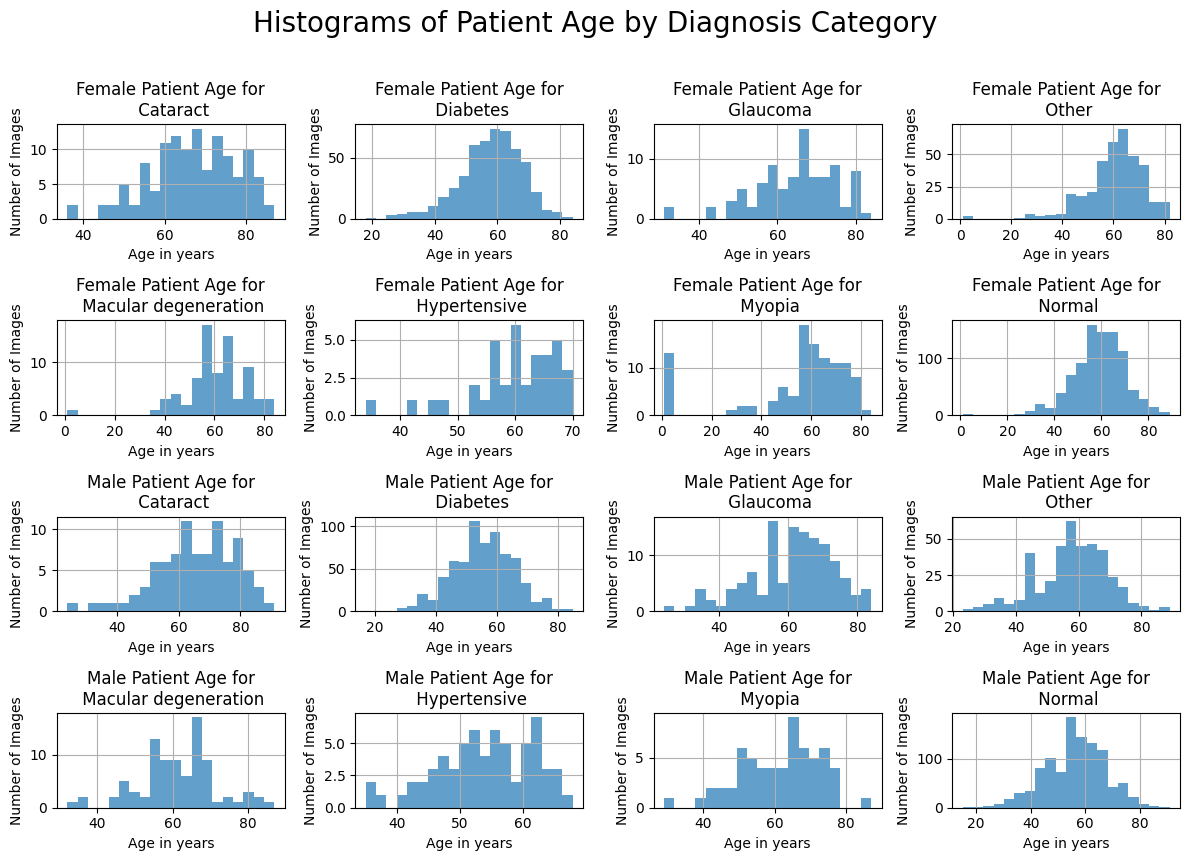

In [15]:
categs = ['C', 'D', 'G', 'O', 'A', 'H', 'M', 'N']

keyword_map = {
    'N': 'Normal',
    'D': 'Diabetes',
    'G': 'Glaucoma',
    'C': 'Cataract',
    'A': 'Macular degeneration',
    'H': 'Hypertensive',
    'M': 'Myopia',
    'O': 'Other'
}

def plot_by_agesexcat(sex, axes, ocular_disease_df, keyword_map, start_idx=0):
    for i, cat in enumerate(categs):
        # Calculate index for the subplot
        idx = start_idx + i
        df_by_cat = ocular_disease_df[((ocular_disease_df[f"Left-{cat}"] == 1) |
                                       (ocular_disease_df[f"Right-{cat}"] == 1)) &
                                       (ocular_disease_df['Patient Sex'] == sex)]
        axes[idx].hist(df_by_cat['Patient Age'], bins=20, alpha=0.7)
        axes[idx].set_title(f"{sex} Patient Age for\n {keyword_map[cat]}")
        axes[idx].grid(True)
        axes[idx].set_xlabel("Age in years")
        axes[idx].set_ylabel("Number of Images")

# Setup for plotting
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
axes = axes.flatten()

# Plot histograms for Female and Male patients, passing the DataFrame and keyword_map as arguments
plot_by_agesexcat('Female', axes, ocular_disease_df, keyword_map)
plot_by_agesexcat('Male', axes, ocular_disease_df, keyword_map, start_idx=len(categs))

plt.tight_layout()
plt.suptitle("Histograms of Patient Age by Diagnosis Category\n", fontsize=20, y=1.07, x =.5)
plt.show()

### Missing Values Check

There were no missing values in any of the columns in the dataframe.

In [ ]:
missing_percentage = ocular_disease_df.isnull().mean() * 100
print("\nPercentage of Missing Values in Each Column:")
print(missing_percentage)


Percentage of Missing Values in Each Column:
ID                           0.0
Patient Age                  0.0
Patient Sex                  0.0
Left-Fundus                  0.0
Right-Fundus                 0.0
Left-Diagnostic Keywords     0.0
Right-Diagnostic Keywords    0.0
Left-N                       0.0
Right-N                      0.0
Left-D                       0.0
Right-D                      0.0
Left-G                       0.0
Right-G                      0.0
Left-C                       0.0
Right-C                      0.0
Left-A                       0.0
Right-A                      0.0
Left-H                       0.0
Right-H                      0.0
Left-M                       0.0
Right-M                      0.0
Left-O                       0.0
Right-O                      0.0
dtype: float64


### Correlation Analysis

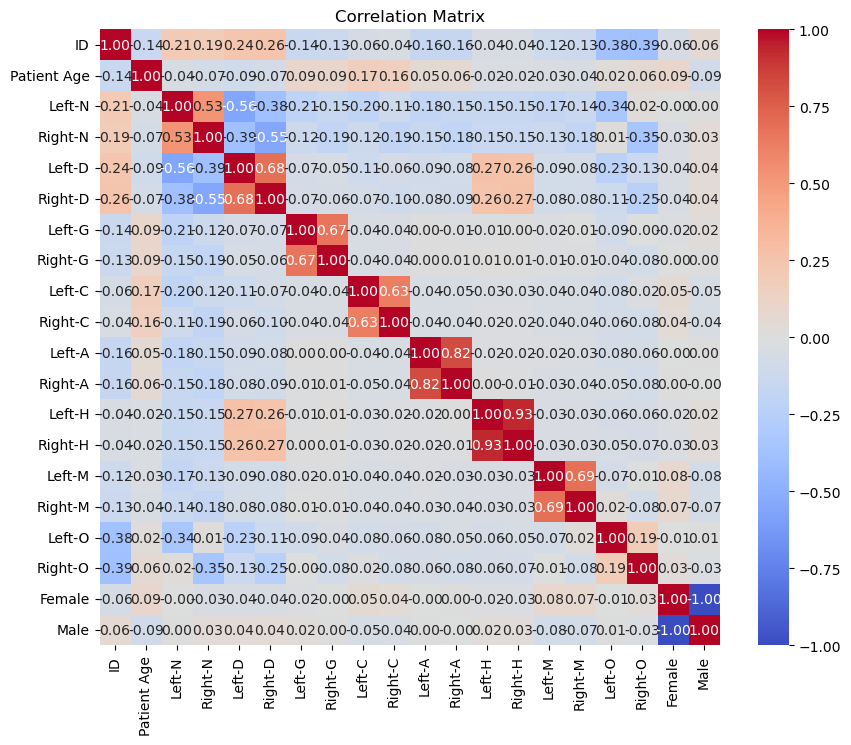

In [ ]:
one_hot_psex = pd.get_dummies(ocular_disease_df['Patient Sex'])

one_hot_psex = ocular_disease_df.join(one_hot_psex)
one_hot_psex.drop(['Patient Sex','Left-Fundus','Right-Fundus','Left-Diagnostic Keywords','Right-Diagnostic Keywords'], axis =1, inplace=True)

correlation_matrix = one_hot_psex.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Number of Examples by Category

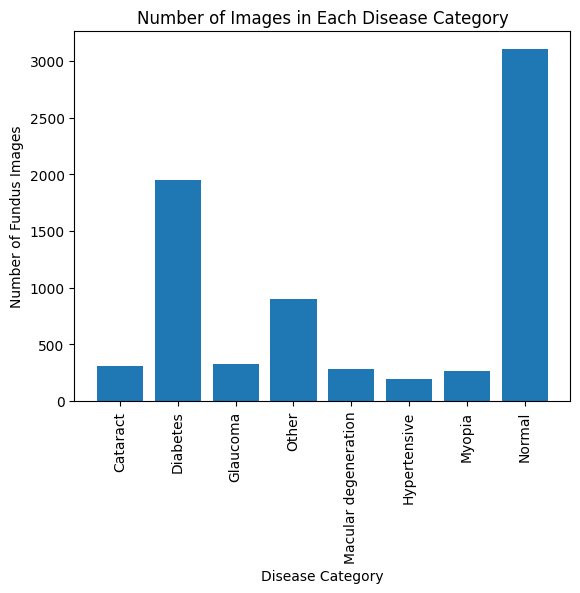

In [14]:
cat_counts = []
full_names = []

categs = ['C', 'D', 'G', 'O', 'A', 'H', 'M', 'N']

keyword_map = {
    'N': 'Normal',
    'D': 'Diabetes',
    'G': 'Glaucoma',
    'C': 'Cataract',
    'A': 'Macular degeneration',
    'H': 'Hypertensive',
    'M': 'Myopia',
    'O': 'Other'
}

for cat in categs:
    full_name = keyword_map[cat]
    full_names.append(full_name)
    cat_counts.append((ocular_disease_df[f'Left-{cat}'].sum() + ocular_disease_df[f'Right-{cat}'].sum()))



plt.bar(x=full_names, height=cat_counts)
plt.title("Number of Images in Each Disease Category")
plt.xlabel("Disease Category")
plt.ylabel("Number of Fundus Images")
plt.xticks(rotation=90)
plt.show()


## Creating Predictive Models

### Splitting Training Data by Category
Variables are assigned for the directory containing the preprocess images, and a second for a directory location where the images will be sorted by diagnosis category.

In [ ]:
# These are the paths to the dataset folders on my local machine.
train_base_dir = 'C:/Users/elanw/OneDrive/Documents/IntroToAI/Final_Project/CV-Prediction-of-Ocular-Disease/ocular-disease-recognition-odir5k/train/'
image_dir = 'C:/Users/elanw/OneDrive/Documents/IntroToAI/Final_Project/CV-Prediction-of-Ocular-Disease/ocular-disease-recognition-odir5k/preprocessed_images/'

The following code creates a subdirectory for each category. It iterates through the dataframe and copies the image over from the source folder containing all images from the data into category folder under training.

In [ ]:
categs = ['C', 'D', 'G', 'O', 'A', 'H', 'M', 'N']

if not os.path.exists(train_base_dir):
        os.mkdir(train_base_dir)

for categ in categs:
    if not os.path.exists(train_base_dir + "\\" + categ):
        os.mkdir(train_base_dir + "\\" + categ)

sides = ['Left','Right']
for side in sides:
      for cat in categs:
        for index,row in ocular_disease_df[ocular_disease_df[f'{side}-{cat}'] == 1].iterrows():
                file = row[f'{side}-Fundus']
                if os.path.isfile(image_dir + file):
                        shutil.copy(image_dir + file, train_base_dir + "/" + cat + "/" + file)

One image exists for each eye, with the text "_left" or "_right" in the image title. In an attempt to increase accuracy, one approach attempted was to duplicate all images and to horizontally mirror the duplicates, given the symmetrical nature of the fundal images. This increased the training size and dramatically impacted training times.

In [ ]:
# This duplicates training data by creating a horizontally flipped version of each.

categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for category in categs:
    for file in os.listdir(train_base_dir + "\\" + category):
        img = cv2.imread(train_base_dir + "\\" + category + "\\" + file)
        flipped_img = cv2.flip(img, 1)
        cv2.imwrite(train_base_dir + "\\" + category + "\\" + file[:-4] + "_flipped.jpg", flipped_img)

Instead of duplicating the data with mirrored examples, mirroring all right images so that the fundus was always on the same side of the image was found to have comparable accuracy and reduced training times.

In [ ]:
categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for category in categs:
    for file in os.listdir(train_base_dir + "\\" + category):
        if file.__contains__("right"):
            img = cv2.imread(train_base_dir + "\\" + category + "\\" + file)
            flipped_img = cv2.flip(img, 1)
            cv2.imwrite(train_base_dir + "\\" + category + "\\" + file[:-4] + ".jpg", flipped_img)

### VGG16 Transfer Learning

A VGG16 model was imported from keras with the pretrained iamgenet weights. The input shape was set to match the fundal images, and a flatten layer, 2 dense layers, and a prediction layer were appended to the model, with softmax activation used for prediction.

In [ ]:
import keras
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet',
                   input_shape=(224, 224, 3),
                   include_top=False)
base_model.trainable = False

In [ ]:
from tensorflow.keras import models, layers
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(80, activation='relu')
dense_layer2 = layers.Dense(40, activation='relu')
prediction_layer = layers.Dense(8, activation='softmax')

xfer_vgg16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer,
    dense_layer2,
    prediction_layer
])

The model was compiled with sparse categorical crossentropy loss as the category labels are exclusive from one another, with image data being assigned a signle label. After experimentation with both adam and a classic SGD optimizer with various alphas, adam was found to have higher accuracy results.

In [ ]:
xfer_vgg16_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# Set up Image Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=False, validation_split=0.2)

In [ ]:
# Flow images from directories with label data
# Setting class mode to sparse categorical for sparse categorical crossentropy
# Batch size 20-32 seems to perform well
# Shuffle set to false for validation data, as .labels and .classes returns labels in order, not matching shuffle status
# Keeping color mode rgb - vgg16 requires 3 input channels, and when using PIL and manually converting to grayscale,
# the model performance was not improved
train_it = train_datagen.flow_from_directory(train_base_dir, target_size=(224, 224), color_mode='rgb', class_mode='sparse', batch_size=32,  subset='training',  shuffle=True)
valid_it = train_datagen.flow_from_directory(train_base_dir, target_size=(224, 224), color_mode='rgb', class_mode='sparse', batch_size=32,  subset='validation', shuffle=False)

Found 5373 images belonging to 8 classes.
Found 1338 images belonging to 8 classes.


In [ ]:
# Fit the model for 20 epochs
xfer_vgg16_model.fit(train_it, epochs=20, validation_data=valid_it)

Epoch 1/20
168/168 [==============================] - 470s 3s/step - loss: 3.7870 - accuracy: 0.4212 - val_loss: 3.0095 - val_accuracy: 0.3976
Epoch 2/20
168/168 [==============================] - 459s 3s/step - loss: 1.7740 - accuracy: 0.5351 - val_loss: 2.8695 - val_accuracy: 0.3535
Epoch 3/20
168/168 [==============================] - 441s 3s/step - loss: 1.1756 - accuracy: 0.6036 - val_loss: 2.1896 - val_accuracy: 0.4761
Epoch 4/20
168/168 [==============================] - 441s 3s/step - loss: 0.9435 - accuracy: 0.6594 - val_loss: 2.1280 - val_accuracy: 0.4148
Epoch 5/20
168/168 [==============================] - 441s 3s/step - loss: 0.9029 - accuracy: 0.6691 - val_loss: 2.0296 - val_accuracy: 0.4626
Epoch 6/20
168/168 [==============================] - 441s 3s/step - loss: 0.7923 - accuracy: 0.7173 - val_loss: 2.3014 - val_accuracy: 0.4200
Epoch 7/20
168/168 [==============================] - 439s 3s/step - loss: 0.7537 - accuracy: 0.7238 - val_loss: 2.1849 - val_accuracy: 0.5067

Above we can see the model continuing to overfit to the training data, while validation accuracy hovers around 40% without improving. These results seem to be consistent regardless of color or greyscale or whether using the SGD optimizer.

In [ ]:
from sklearn.metrics import accuracy_score
predictions = xfer_vgg16_model.predict(valid_it)
score = accuracy_score(y_true=valid_it.classes, y_pred=predictions.argmax(axis=-1))
print(score)

42/42 [==============================] - 89s 2s/step
0.476831091180867


In [ ]:

import sklearn.metrics as metrics
print(metrics.classification_report(valid_it.classes, predictions.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.64      0.57      0.60        60
           2       0.42      0.46      0.44       371
           3       0.22      0.27      0.24        62
           4       0.00      0.00      0.00        38
           5       0.59      0.32      0.42        50
           6       0.58      0.67      0.62       575
           7       0.21      0.13      0.16       127

    accuracy                           0.48      1338
   macro avg       0.33      0.30      0.31      1338
weighted avg       0.45      0.48      0.46      1338



Above we can see that while the weakest performance is on the class with the fewest examples (4).

In [ ]:
# Same attempt, but with VGG19
import keras
from tensorflow.keras.applications import VGG19
base_model = VGG16(weights='imagenet',
                   input_shape=(224, 224, 3),
                   include_top=False)
base_model.trainable = False
from tensorflow.keras import models, layers
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(80, activation='relu')
dense_layer2 = layers.Dense(40, activation='relu')
prediction_layer = layers.Dense(8, activation='softmax')

xfer_vgg19_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer,
    dense_layer2,
    prediction_layer
])
xfer_vgg19_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
xfer_vgg19_model.fit(train_it, epochs=20, validation_data=valid_it)

Epoch 1/20
168/168 [==============================] - 438s 3s/step - loss: 2.4516 - accuracy: 0.4085 - val_loss: 1.8732 - val_accuracy: 0.4402
Epoch 2/20
168/168 [==============================] - 438s 3s/step - loss: 1.3854 - accuracy: 0.5079 - val_loss: 1.7300 - val_accuracy: 0.4268
Epoch 3/20
168/168 [==============================] - 440s 3s/step - loss: 1.2070 - accuracy: 0.5563 - val_loss: 1.6780 - val_accuracy: 0.4880
Epoch 4/20
168/168 [==============================] - 444s 3s/step - loss: 1.0730 - accuracy: 0.6054 - val_loss: 1.9118 - val_accuracy: 0.4268
Epoch 5/20
168/168 [==============================] - 443s 3s/step - loss: 1.0081 - accuracy: 0.6222 - val_loss: 1.7847 - val_accuracy: 0.4410
Epoch 6/20
168/168 [==============================] - 443s 3s/step - loss: 0.9473 - accuracy: 0.6449 - val_loss: 1.8186 - val_accuracy: 0.4581
Epoch 7/20
168/168 [==============================] - 442s 3s/step - loss: 0.8915 - accuracy: 0.6592 - val_loss: 1.7480 - val_accuracy: 0.4357

In [ ]:
# Show the accuracy score

predictions = xfer_vgg19_model.predict(valid_it)
score = accuracy_score(y_true=valid_it.classes, y_pred=predictions.argmax(axis=-1))
print(score)

42/42 [==============================] - 90s 2s/step
0.414050822122571


In [ ]:
# Display the classification report with precision, recall, and f1-score
# and number of examples for each category

print(metrics.classification_report(valid_it.classes, predictions.argmax(axis=-1)))


              precision    recall  f1-score   support

           0       0.16      0.09      0.12        55
           1       0.47      0.57      0.52        60
           2       0.35      0.50      0.42       371
           3       0.15      0.27      0.19        62
           4       0.07      0.08      0.07        38
           5       0.54      0.64      0.59        50
           6       0.63      0.46      0.53       575
           7       0.18      0.10      0.13       127

    accuracy                           0.41      1338
   macro avg       0.32      0.34      0.32      1338
weighted avg       0.44      0.41      0.42      1338



In [ ]:
# Setup of non-pretrained CNN, with 4 convolutional layers, 4 max pooling layers, 4 dense layers, and 4 dropout layers
# An initial attempt had a very slow learning rate, with a peak of 44% on training and validation at 20 epochs
# Doubling the batch size to speed up learning
from tensorflow.keras.optimizers import SGD
sgd_optimizer = SGD(lr = 0.1)

cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (224,224,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,
    tf.keras.layers.MaxPooling2D((2,2),strides = 2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D((2,2),strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(550,activation="relu"),
    tf.keras.layers.Dropout(0.1,seed = 2019),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = 2019),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.4,seed = 2019),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(8,activation = "softmax")
])

cnn_model.compile(optimizer = 'adam' , loss = "sparse_categorical_crossentropy" , metrics = ["accuracy"])

In [ ]:
# WITH sgd with high learning rate
cnn_model.fit(train_it, epochs=40, validation_data=valid_it)

Epoch 1/40
168/168 [==============================] - 115s 675ms/step - loss: 2.3783 - accuracy: 0.4063 - val_loss: 1.6070 - val_accuracy: 0.4297
Epoch 2/40
168/168 [==============================] - 112s 665ms/step - loss: 1.5959 - accuracy: 0.4255 - val_loss: 1.5796 - val_accuracy: 0.4290
Epoch 3/40
168/168 [==============================] - 112s 667ms/step - loss: 1.5898 - accuracy: 0.4197 - val_loss: 1.5712 - val_accuracy: 0.4305
Epoch 4/40
168/168 [==============================] - 116s 690ms/step - loss: 1.5716 - accuracy: 0.4318 - val_loss: 1.5688 - val_accuracy: 0.4312
Epoch 5/40
168/168 [==============================] - 111s 662ms/step - loss: 1.5747 - accuracy: 0.4374 - val_loss: 1.5975 - val_accuracy: 0.4357
Epoch 6/40
168/168 [==============================] - 116s 691ms/step - loss: 1.5706 - accuracy: 0.4363 - val_loss: 1.5642 - val_accuracy: 0.4425
Epoch 7/40
168/168 [==============================] - 113s 673ms/step - loss: 1.5693 - accuracy: 0.4268 - val_loss: 1.5588 -

In [ ]:
# Fit with adam optimizer
cnn_model.fit(train_it, epochs=20, validation_data=valid_it)

Epoch 1/20
168/168 [==============================] - 105s 620ms/step - loss: 2.6461 - accuracy: 0.3962 - val_loss: 1.6319 - val_accuracy: 0.4297
Epoch 2/20
168/168 [==============================] - 101s 600ms/step - loss: 1.6049 - accuracy: 0.4243 - val_loss: 1.5858 - val_accuracy: 0.4290
Epoch 3/20
168/168 [==============================] - 99s 590ms/step - loss: 1.5861 - accuracy: 0.4314 - val_loss: 1.5725 - val_accuracy: 0.4342
Epoch 4/20
168/168 [==============================] - 102s 605ms/step - loss: 1.5765 - accuracy: 0.4336 - val_loss: 1.5682 - val_accuracy: 0.4350
Epoch 5/20
168/168 [==============================] - 106s 628ms/step - loss: 1.5687 - accuracy: 0.4312 - val_loss: 1.5588 - val_accuracy: 0.4454
Epoch 6/20
168/168 [==============================] - 107s 637ms/step - loss: 1.5618 - accuracy: 0.4390 - val_loss: 1.5572 - val_accuracy: 0.4410
Epoch 7/20
168/168 [==============================] - 108s 641ms/step - loss: 1.5534 - accuracy: 0.4301 - val_loss: 1.5622 - 

In [ ]:
cnn_model_simpler = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (224,224,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,
    tf.keras.layers.MaxPooling2D((2,2),strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(8,activation = "softmax")
])
cnn_model_simpler.compile(optimizer = 'adam' , loss = "sparse_categorical_crossentropy" , metrics = ["accuracy"])
cnn_model_simpler.fit(train_it, epochs=20, validation_data=valid_it)

Epoch 1/20
168/168 [==============================] - 147s 871ms/step - loss: 77.4023 - accuracy: 0.3871 - val_loss: 1.6499 - val_accuracy: 0.4342
Epoch 2/20
168/168 [==============================] - 143s 853ms/step - loss: 1.6012 - accuracy: 0.4413 - val_loss: 1.5950 - val_accuracy: 0.4410
Epoch 3/20
168/168 [==============================] - 143s 853ms/step - loss: 1.5399 - accuracy: 0.4510 - val_loss: 1.5760 - val_accuracy: 0.4387
Epoch 4/20
168/168 [==============================] - 142s 845ms/step - loss: 1.4928 - accuracy: 0.4586 - val_loss: 1.5873 - val_accuracy: 0.4297
Epoch 5/20
168/168 [==============================] - 147s 876ms/step - loss: 1.4623 - accuracy: 0.4712 - val_loss: 1.5986 - val_accuracy: 0.4350
Epoch 6/20
168/168 [==============================] - 146s 866ms/step - loss: 1.4324 - accuracy: 0.4718 - val_loss: 1.6031 - val_accuracy: 0.4350
Epoch 7/20
168/168 [==============================] - 140s 835ms/step - loss: 1.4020 - accuracy: 0.4778 - val_loss: 1.6085 

## SVM

In [ ]:
# Configuring a Support Vector Classification model and attempting to fit it to the data results running out of memory and crashing the kernel.
# After exploration, this continues to occur even with compressed images and using only 10% of the dataset on a machine with 51GB of RAM.
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=False, validation_split=0.9)
train_it = train_datagen.flow_from_directory(train_base_dir, target_size=(150, 150), color_mode='greyscale', class_mode='sparse', batch_size=32,  subset='training',  shuffle=False)
valid_it = train_datagen.flow_from_directory(train_base_dir, target_size=(150, 150), color_mode='greyscale', class_mode='sparse', batch_size=32,  subset='validation', shuffle=False)

support_vector_model = SVC(gamma = .01, C = 100)
support_vector_model.fit(train_it, train_it.labels)

### Helper Functions

In [ ]:
# Helpful function to show an image

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

show_image('C:\\Users\\elanw\\OneDrive\\Pictures\\eye_square.jpg')

In [ ]:
# Helper function to load image from path and preprocess it


def load_and_process_image(image_path):
    img = image_utils.load_img(image_path, target_size=(224,224))
    img = image_utils.img_to_array(img)
    img = img.reshape(1,224,224,3)
    img = preprocess_input(img)
    return img